In [1007]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy

In [1132]:
csv_file = 'COVID_Data_SLC/Summary_Case Counts per Week.csv'
data = pd.read_csv(csv_file, index_col=0)

In [1137]:
data[:'2021-03-07'].shape

(53, 1)

In [3]:
# ---------- Function for parsing infected data ----------  #
def parse_infected_data(file):
    """Parse weekly new case count data.

    All data is in 1-week increments here.
    Testing data starts the week after the training data ends.

    Parameters:
        file (str): The path to "Summary_Case Counts Per Week.csv"

    Returns:
        train (np.ndarray) - An array of weekly new COVID case counts
            for training (the weeks from 3/8/2020 to 12/12/2021).
            Use for your gradient descent algorithm and modeling.
        test (np.ndarray) - An array of weekly new COVID case counts
            for testing (the weeks from 12/19/2021 to 1/19/2022).
            Only use to test the performance of your model on its
            learned parameters after you run your gradient descent
            algorithm.
        t_train (list) - A list of numbered weeks
            corresponding to the training data (starting with 1)
        t_test (list) - A list of numbered weeks
            corresponding to the testing data (starting 1 after
            the training data)
    """
    # Get the case count data from the csv into Python
    data = pd.read_csv(file, index_col=0)

    # Split the data into a training set(before 12/12/2021)
    # and a testing set (12/19/2021-1/19/2022)
    #train = data[:]['New Cases'].to_numpy()
    train = data[:'2021-12-12']['New Cases'].to_numpy()
    test = data['2021-12-19':'2022-01-19']['New Cases'].to_numpy()

    # Get week enumerations for this data (for ease of use)
    t_train = [i for i in range(1, len(train) + 1)]
    t_test = [i for i in range(len(train)+1, len(test)+len(train)+1)]
    return train, test, t_train, t_test



# ---------- Example for how to use the above function ----------  #
csv_file = 'COVID_Data_SLC/Summary_Case Counts per Week.csv'
case_count_data, case_count_pred, t_cc_data, t_cc_pred = parse_infected_data(csv_file)


In [4]:
# ---------- Function for parsing infected data ----------  #
def parse_death_data(file):
    """Parse weekly new case count data.

    All data is in 1-week increments here.
    Testing data starts the week after the training data ends.

    Parameters:
        file (str): The path to "Summary_Case Counts Per Week.csv"

    Returns:
        train (np.ndarray) - An array of weekly new COVID case counts
            for training (the weeks from 3/8/2020 to 12/12/2021).
            Use for your gradient descent algorithm and modeling.
        test (np.ndarray) - An array of weekly new COVID case counts
            for testing (the weeks from 12/19/2021 to 1/19/2022).
            Only use to test the performance of your model on its
            learned parameters after you run your gradient descent
            algorithm.
        t_train (list) - A list of numbered weeks
            corresponding to the training data (starting with 1)
        t_test (list) - A list of numbered weeks
            corresponding to the testing data (starting 1 after
            the training data)
    """
    # Get the case count data from the csv into Python
    data = pd.read_csv(file, index_col=0)

    # Split the data into a training set(before 12/12/2021)
    # and a testing set (12/19/2021-1/19/2022)
    train = data[:'2021-12-12']['New Deaths'].to_numpy()
    test = data['2021-12-19':'2022-01-19']['New Deaths'].to_numpy()

    # Get week enumerations for this data (for ease of use)
    t_train = [i for i in range(1, len(train) + 1)]
    t_test = [i for i in range(len(train)+1, len(test)+len(train)+1)]
    return train, test, t_train, t_test



# ---------- Example for how to use the above function ----------  #
csv_file = 'COVID_Data_SLC/Deaths_Counts per Week.csv'
death_data, death_pred, t_death_data, t_death_pred = parse_death_data(csv_file)


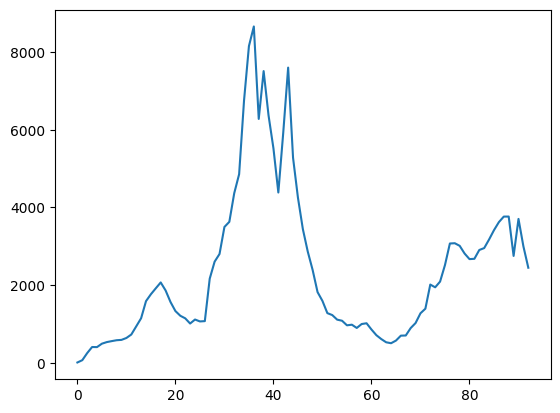

In [5]:
plt.plot(case_count_data)
plt.show()

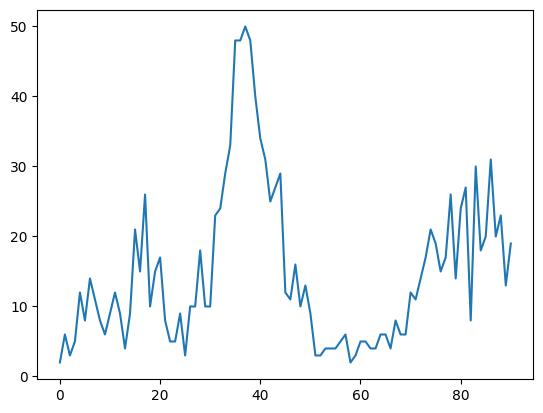

In [6]:
plt.plot(death_data)
plt.show()

In [7]:
len(case_count_data), len(death_data)

(93, 91)

In [8]:
sum(case_count_data[:0])

0

In [810]:
P_total = 1000000

In [811]:
I_data = np.array([sum(case_count_data[:k]) for k in range(1, 4)] + [sum(case_count_data[k:k+4]) for k in range(len(case_count_data) - 3)])
R_data = np.array([0, 0, 0] + [sum(case_count_data[:k]) for k in range(len(case_count_data) - 3)])

I_data = I_data / P_total
R_data = R_data / P_total

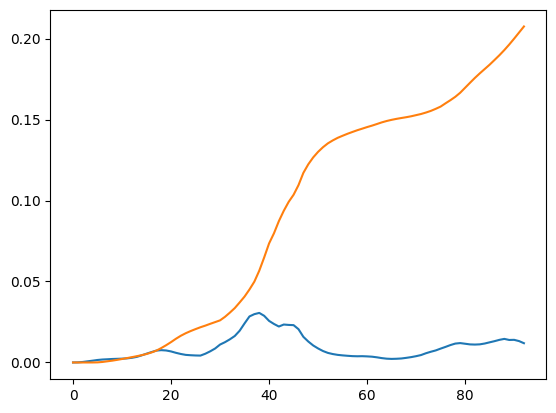

In [812]:
plt.plot(I_data)
plt.plot(R_data)

In [815]:
N = len(t_cc_data)
c = 1
a = np.zeros(5)
b = np.zeros(5)
k = lambda x: c + sum(a[i]*np.cos(2*np.pi*x*i / 52) + b[i]*np.sin(2*np.pi*x*i / 52) for i in range(len(a)))
#time_steps = np.linspace(0, N / 52, N, endpoint=False)
time_steps = np.array(t_cc_data)

In [816]:
I_poly = np.poly1d(np.polyfit(time_steps, I_data, 20))
R_poly = np.poly1d(np.polyfit(time_steps, R_data, 20))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


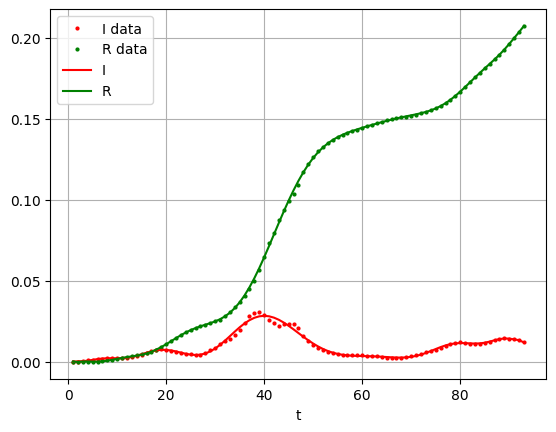

In [817]:
plt.plot(time_steps, I_data,'ro', label='I data', ms = 2)
plt.plot(time_steps, R_data,'go', label='R data', ms = 2)

plt.plot(time_steps, I_poly(time_steps), 'r', label="I")
plt.plot(time_steps, R_poly(time_steps), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()


In [818]:
from scipy.integrate import odeint, solve_bvp, solve_ivp, quad

In [880]:
def fourier_series(t, *args):
    t = np.array(t)
    N = (len(args) - 1) // 2
    c = args[0]
    a = args[1:N+1]
    b = args[N+1:]
    return c + sum(a[i]*np.cos(2*np.pi*t*i/52) + b[i]*np.sin(2*np.pi*t*i/52) for i in range(N))


In [821]:
k = lambda c, a, b, x: c + sum(a[i]*np.cos(2*np.pi*x*i/52) + b[i]*np.sin(2*np.pi*x*i/52) for i in range(len(a)))
q = lambda c, a, b, x: c + sum(a[i]*np.cos(2*np.pi*x*i/52) + b[i]*np.sin(2*np.pi*x*i/52) for i in range(len(a)))

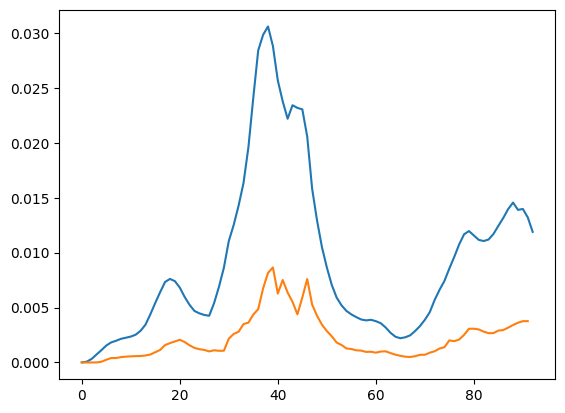

In [864]:
R_t = np.array([R_data[t+1] - R_data[t] for t in range(N - 1)])
plt.plot(I_data)
plt.plot(R_t)

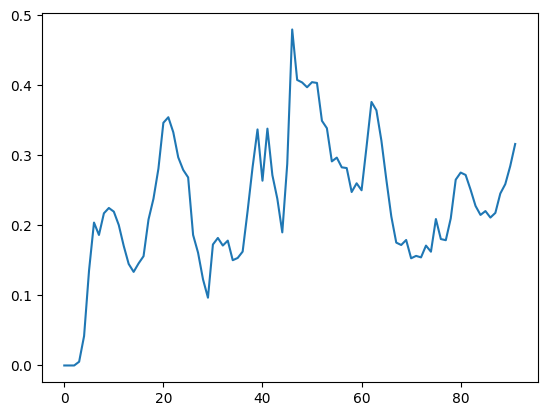

In [865]:
q_data = np.array(R_t) / np.array(I_data[1:])
plt.plot(q_data)

In [1202]:
from scipy.optimize import curve_fit
q_guess, _ = curve_fit(fourier_series, t_cc_data[:-1], q_data, p0=(0.2, *np.zeros(10), *np.zeros(10)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


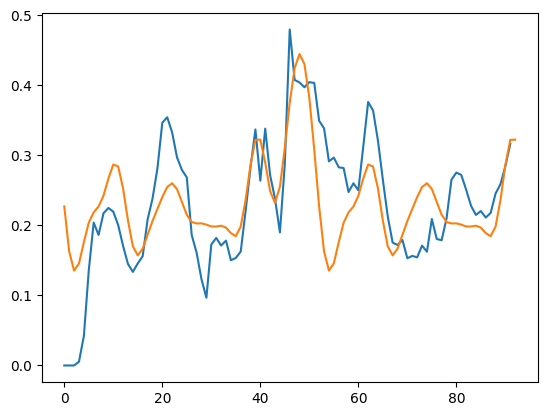

In [1203]:
plt.plot(q_data)
plt.plot(fourier_series(t_cc_data, *q_guess))

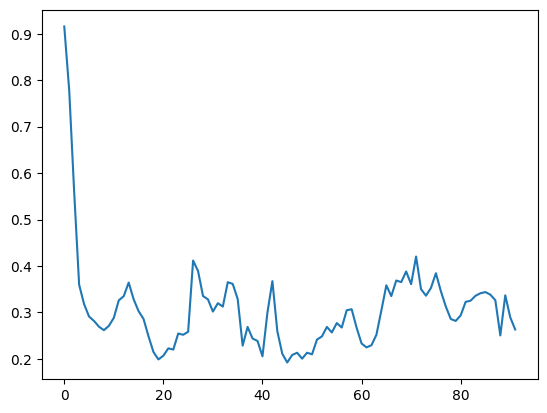

In [1205]:
S = np.ones_like(I_data) - I_data - R_data
S_t = np.array([S[t+1] - S[t] for t in range(N - 1)])
k_data = -S_t / (S[1:]*I_data[1:])
plt.plot(k_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


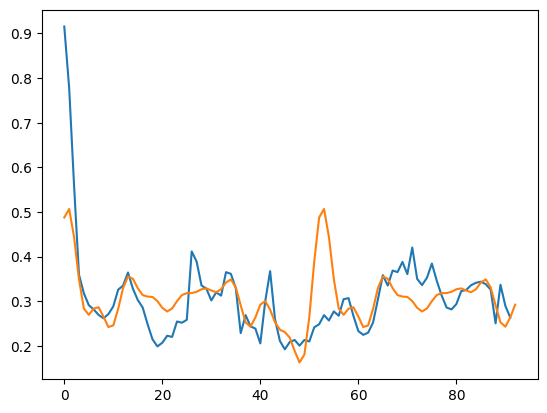

In [1206]:
k_guess, _ = curve_fit(fourier_series, t_cc_data[:-1], k_data, p0=(0.3, *np.zeros(10), *np.zeros(10)))
plt.plot(k_data)
plt.plot(fourier_series(t_cc_data, *k_guess))

In [928]:
def ode_fun(t, u, *args):
    N = len(args) // 2

    out = np.zeros(3)

    S = u[0]
    I = u[1]
    R = u[2]

    out[0] = -fourier_series(t, *args[:N])*S*I
    out[1] = fourier_series(t, *args[:N])*S*I-fourier_series(t, *args[N:])*I
    out[2] = fourier_series(t, *args[N:])*I

    return out

# Initial guess
I0 = 0.0006
R0 = R_data[0]
S0 = 1 - I0 - R0

u0 = [S0, I0, R0]
SIR_sol = solve_ivp(ode_fun, [0, 93], u0, args=(*k_guess, *q_guess), dense_output=True)

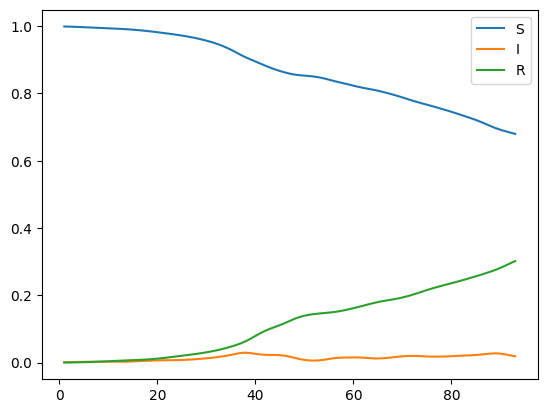

In [929]:
plt.plot(time_steps, SIR_sol.sol(time_steps)[0], label="S")
plt.plot(time_steps, SIR_sol.sol(time_steps)[1], label="I")
plt.plot(time_steps, SIR_sol.sol(time_steps)[2], label="R")
plt.legend()
plt.show()

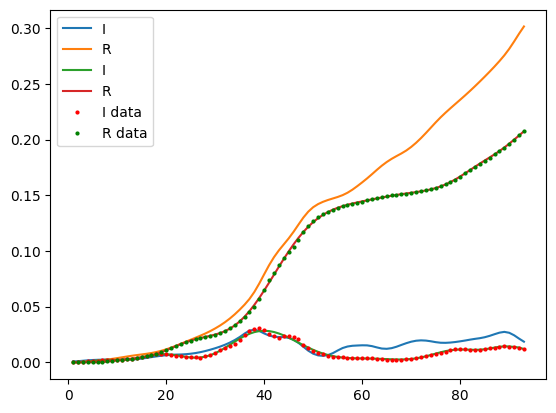

In [930]:
plt.plot(time_steps, SIR_sol.sol(time_steps)[1], label="I")
plt.plot(time_steps, SIR_sol.sol(time_steps)[2], label="R")
plt.plot(time_steps, I_poly(time_steps), label="I")
plt.plot(time_steps, R_poly(time_steps), label="R")
plt.plot(time_steps, I_data,'ro', label='I data', ms = 2)
plt.plot(time_steps, R_data,'go', label='R data', ms = 2)
plt.legend()
plt.show()

In [931]:
def ode_adjoint(t, P):
    S = SIR_sol.sol(t)[0]
    I = SIR_sol.sol(t)[1]
    R = SIR_sol.sol(t)[2]
    
    P_S = fourier_series(t, *k_guess)*I*(P[0] - P[1])
    P_I = I - I_poly(t) + fourier_series(t, *k_guess)*S*(P[0] - P[1]) + fourier_series(t, *q_guess)*(P[1] - P[2])
    P_R = R - R_poly(t)

    return np.vstack([P_S, P_I, P_R])

def adjoint_bc(Pa, Pb):
    return np.array([Pb[0], Pb[1], Pb[2]])

t_mesh = np.linspace(0, 93, 10)
P0 = np.ones((3, t_mesh.size))
p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

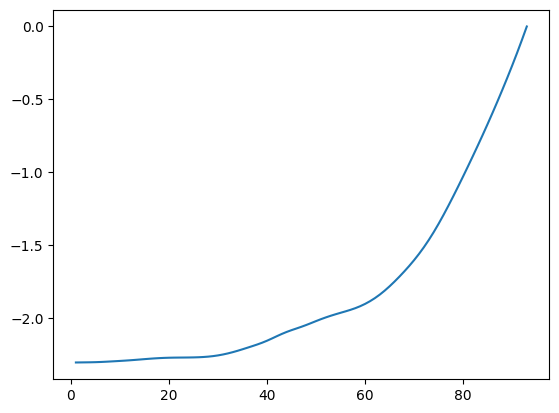

In [935]:
plt.plot(t_cc_data, p.sol(t_cc_data)[2])

In [681]:
p.p

array([-0.01707817])

In [937]:
DJ_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
DJ_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

dt = time_steps[1] - time_steps[0]
DJ_k = sum(DJ_k_func(t)*dt for t in time_steps)
DJ_q = sum(DJ_q_func(t)*dt for t in time_steps)
DJ_S0 = -p.sol(0)[0]
DJ_I0 = -p.sol(0)[1]
DJ_R0 = -p.sol(0)[2]

DJ_k, DJ_q, DJ_S0, DJ_I0, DJ_R0

(11.577572993429431,
 -11.68311667515364,
 3.9334670887431,
 314.49666240839804,
 2.301586689438324)

In [949]:
np.set_printoptions(suppress=True, precision=8)

In [1016]:
N = len(t_cc_data)
num_coefs = 10
k = np.copy(k_guess)
q = np.copy(q_guess)
I0 = 0.0006
R0 = R_data[0]
S0 = 1 - I0 - R0
u0 = np.array([S0, I0, R0])

n_iter = 10
lr = 0.01

cost_hist = []
param_hist = []

In [1186]:
n_iter = 20
lr = 0.001
for i in range(n_iter):
    print("Step {}".format(i))

    SIR_sol = solve_ivp(ode_fun, [0, 100], u0, args=(*k, *q), dense_output=True)

    cost_func = lambda t: (SIR_sol.sol(t)[1] - I_poly(t))**2 + (SIR_sol.sol(t)[2] - R_poly(t))**2 
    J = 0.5 * quad(cost_func, 0, N)[0]
    print("Cost: {:.6}".format(J))
    cost_hist.append(J)

    def ode_adjoint(t, P):
        S = SIR_sol.sol(t)[0]
        I = SIR_sol.sol(t)[1]
        R = SIR_sol.sol(t)[2]
        
        P_S = fourier_series(t, *k)*I*(P[0] - P[1])
        P_I = I - I_poly(t) + fourier_series(t, *k)*S*(P[0] - P[1]) + fourier_series(t, *q)*(P[1] - P[2])
        P_R = R - R_poly(t)

        return np.vstack([P_S, P_I, P_R])

    def adjoint_bc(Pa, Pb):
        return np.array([Pb[0], Pb[1], Pb[2]])

    t_mesh = np.linspace(0, 93, 10)
    P0 = np.ones((3, t_mesh.size))
    p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

    J_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
    J_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

    J_c_k = sum(DJ_k_func(t) for t in range(N))
    J_a_k = []
    J_b_k = []

    J_c_q = sum(DJ_q_func(t) for t in range(N))
    J_a_q = []
    J_b_q = []
    
    for i in range(1, num_coefs+1):
        J_a_k.append(sum(DJ_k_func(t)*np.cos(2*np.pi*t*i)*dt for t in time_steps))
        J_b_k.append(sum(DJ_k_func(t)*np.sin(2*np.pi*t*i)*dt for t in time_steps))
        J_a_q.append(sum(DJ_q_func(t)*np.cos(2*np.pi*t*i)*dt for t in time_steps))
        J_b_q.append(sum(DJ_q_func(t)*np.sin(2*np.pi*t*i)*dt for t in time_steps))

    J_S0 = -p.sol(0)[0]
    J_I0 = -p.sol(0)[1]
    J_R0 = -p.sol(0)[2]

    u_grad = np.array([J_I0 - J_S0, J_R0 - J_S0])
    k_grad = np.array([J_c_k] + J_a_k + J_b_k)
    q_grad = np.array([J_c_q] + J_a_q + J_b_q)

    # print(u0)
    # print(k)
    # print(q)
    # print()

    # print(u_grad)
    # print(k_grad)
    # print(q_grad)
    # print()
    k -= lr*k_grad / np.linalg.norm(k_grad)
    q -= lr*q_grad / np.linalg.norm(q_grad)
    u0[1:] -= 0.001*lr*u_grad / np.linalg.norm(u_grad)
    u0[0] = 1 - u0[1] - u0[2]

    # print(u0)
    # print(k)
    # print(q)

    
    print()



    

Step 0
Cost: 0.00185174

Step 1
Cost: 0.00220632

Step 2
Cost: 0.00188535

Step 3
Cost: 0.00222681

Step 4
Cost: 0.0018836

Step 5
Cost: 0.00224358

Step 6
Cost: 0.00199969

Step 7
Cost: 0.00216681

Step 8
Cost: 0.0019913

Step 9
Cost: 0.00220899

Step 10
Cost: 0.00197215

Step 11
Cost: 0.00224386

Step 12
Cost: 0.00195963

Step 13
Cost: 0.00240325

Step 14
Cost: 0.00194673

Step 15
Cost: 0.00247656

Step 16
Cost: 0.00179301

Step 17
Cost: 0.00248019

Step 18
Cost: 0.00180002

Step 19
Cost: 0.00255051



In [761]:
n_iter = 1000
lr = 10

for i in range(n_iter):
    print("Step {}".format(i))

    u0 = [S0, I0, R0]
    SIR_sol = solve_ivp(ode_fun, [0, 2], u0, args=(c, a, b, q), dense_output=True)

    cost_func = lambda t: (SIR_sol.sol(t)[1] - I_poly(t))**2
    J = 0.5 * quad(cost_func, 0, N/52)[0]
    print("Cost: {:.6}".format(J))
    cost_hist.append(J)

    # def ode_adjoint(t, P):
    #     S = SIR_sol.sol(t)[0]
    #     I = SIR_sol.sol(t)[1]
    #     R = SIR_sol.sol(t)[2]
        
    #     P_S = k(c, a, b, t)*I*(P[0] - P[1])
    #     P_I = I - I_poly(t) + k(c, a, b, t)*S*(P[0] - P[1]) + q*(P[1] - P[2])
    #     P_R = R - R_poly(t)

    #     return np.vstack([P_S, P_I, P_R])
    
    # def adjoint_bc(Pa, Pb):
    #     return np.array([Pb[0], Pb[1], Pb[2]])

    # t_mesh = np.linspace(0, N/52, 10)
    # p0 = np.ones((3, t_mesh.size))
    # p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, p0)

    def ode_adjoint(t, P, P_R):
        S = SIR_sol.sol(t)[0]
        I = SIR_sol.sol(t)[1]
        R = SIR_sol.sol(t)[2]
        
        P_S = k(c, a, b, t)*I*(P[0] - P[1])
        P_I = I - I_poly(t) + k(c, a, b, t)*S*(P[0] - P[1]) + q0*(P[1] - P_R[0])

        return np.vstack([P_S, P_I])

    def adjoint_bc(Pa, Pb, P_R):
        return np.array([Pb[0], Pb[1], Pa[0]])

    t_mesh = np.linspace(0, 93/52, 10)
    P0 = np.ones((2, t_mesh.size))
    p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0, p=[0])


    dt = time_steps[1] - time_steps[0]
    DJ_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
    #DJ_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])
    DJ_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.p[0])

    DJ_c = sum(DJ_k_func(t)*dt for t in time_steps)
    DJ_a = []
    DJ_b = []
    
    for i in range(1, num_coefs+1):
        DJ_a.append(sum(DJ_k_func(t)*np.cos(2*np.pi*t*i)*dt for t in time_steps))
        DJ_b.append(sum(DJ_k_func(t)*np.sin(2*np.pi*t*i)*dt for t in time_steps))

    DJ_q = sum(DJ_q_func(t)*dt for t in time_steps)
    #DJ_S0 = -p.sol(0)[0]
    DJ_I0 = -p.sol(0)[1]
    DJ_R0 = -p.p[0]
    
    #print(DJ_S0, DJ_I0, DJ_R0)

    # etas = lr * (np.random.randn(10) - 0.5)
    # print(etas)
    # for eta in etas:
    #     if I0 + eta*(DJ_I0 - DJ_S0) < 0 or I0 + eta*(DJ_I0 - DJ_S0) > 1: continue
    #     if R0 + eta*(DJ_R0 - DJ_S0) < 0 or R0 + eta*(DJ_R0 - DJ_S0) > 1: continue

    #     _c = c + eta*DJ_c
    #     _a = a + eta*np.array(DJ_a)
    #     _b = b + eta*np.array(DJ_b)
    #     _q = q + eta*DJ_q
    #     _I0 = I0 + eta*(DJ_I0 - DJ_S0)
    #     _R0 = R0 + eta*(DJ_R0 - DJ_S0)
    #     _S0 = 1 - _I0 - _R0

    #     SIR_new = solve_ivp(ode_fun, [0, 2], [_S0, _I0, _R0], args=(_c, _a, _b, _q), dense_output=True)
    #     new_cost_func = lambda t: (SIR_new.sol(t)[1] - I_poly(t))**2
    #     J = 0.5 * quad(new_cost_func, 0, N/52)[0]
    #     print(J)


    c -= lr*DJ_c
    a -= lr*np.array(DJ_a)
    b -= lr*np.array(DJ_b)
    q -= lr*DJ_q
    #I0 -= lr*(DJ_I0 - DJ_S0)
    #R0 -= lr*(DJ_R0 - DJ_S0)
    #I0 -= 0.001*lr*(DJ_I0)
    #R0 -= 0.001*lr*(DJ_R0)
    #S0 = 1 - I0 - R0

    print()



    

Step 0
Cost: 7.5295e-05

Step 1
Cost: 7.52767e-05

Step 2
Cost: 7.52586e-05

Step 3
Cost: 7.52405e-05

Step 4
Cost: 7.52226e-05

Step 5
Cost: 7.52048e-05

Step 6
Cost: 7.51871e-05

Step 7
Cost: 7.51695e-05

Step 8
Cost: 7.51521e-05

Step 9
Cost: 7.51347e-05

Step 10
Cost: 7.51175e-05

Step 11
Cost: 7.51004e-05

Step 12
Cost: 7.50834e-05

Step 13
Cost: 7.50665e-05

Step 14
Cost: 7.50497e-05

Step 15
Cost: 7.5033e-05

Step 16
Cost: 7.50165e-05

Step 17
Cost: 7.5e-05

Step 18
Cost: 7.49836e-05

Step 19
Cost: 7.49674e-05

Step 20
Cost: 7.49513e-05

Step 21
Cost: 7.49352e-05

Step 22
Cost: 7.49193e-05

Step 23
Cost: 7.49035e-05

Step 24
Cost: 7.48877e-05

Step 25
Cost: 7.48721e-05

Step 26
Cost: 7.48566e-05

Step 27
Cost: 7.48411e-05

Step 28
Cost: 7.48258e-05

Step 29
Cost: 7.48106e-05

Step 30
Cost: 7.47954e-05

Step 31
Cost: 7.47804e-05

Step 32
Cost: 7.47654e-05

Step 33
Cost: 7.47506e-05

Step 34
Cost: 7.47358e-05

Step 35
Cost: 7.47212e-05

Step 36
Cost: 7.47066e-05

Step 37
Cost: 7.4

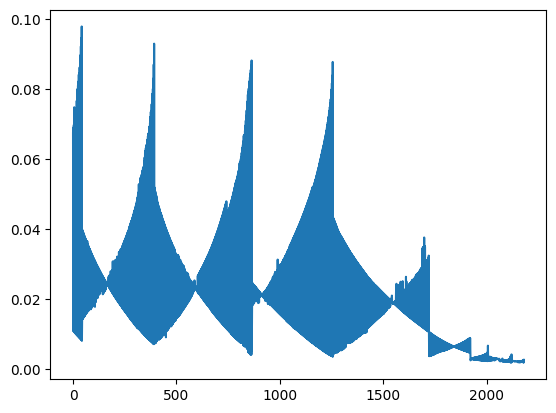

In [1187]:
plt.plot(cost_hist)

In [1188]:
k

array([ 21.5347784 , -21.22289899,  -0.02022339,   0.00554203,
         0.02165081,   0.00748686,  -0.003586  ,   0.00734781,
        -0.00278358,  -0.00946625,  -0.01153406,   0.        ,
         0.01558478,   0.03057453,   0.0184728 ,   0.04226202,
         0.03544838,   0.01601015,   0.01002258,   0.02336165,
         0.02087636])

In [1189]:
q

array([-13.92494491,  14.19238872,   0.06967339,   0.04040091,
         0.01576099,   0.04776961,   0.05022714,   0.01232768,
         0.01460599,   0.03129847,   0.03798651,  -0.        ,
        -0.02597234,  -0.0419952 ,  -0.02715945,  -0.04671801,
        -0.02641996,  -0.02113141,  -0.00692738,  -0.00022535,
         0.00149151])

In [1190]:
u0

array([0.99934289, 0.00061249, 0.00004462])

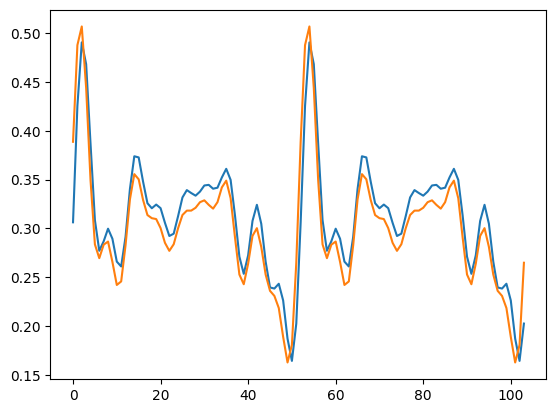

In [1196]:
t = np.arange(104)
plt.plot(fourier_series(t, *k))
plt.plot(fourier_series(t, *k_guess))

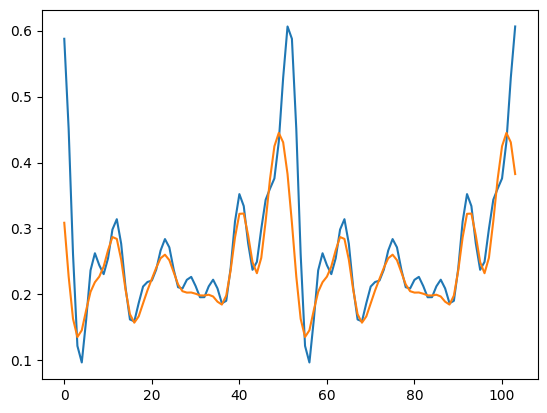

In [1197]:
plt.plot(fourier_series(t, *q))
plt.plot(fourier_series(t, *q_guess))

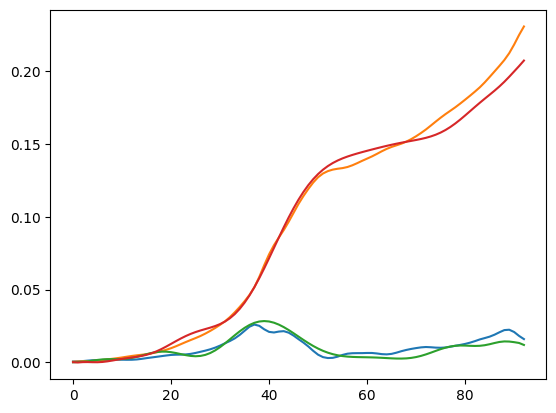

In [1198]:
plt.plot(SIR_sol.sol(t_cc_data)[1])
plt.plot(SIR_sol.sol(t_cc_data)[2])
plt.plot(I_poly(t_cc_data), label="I")
plt.plot(R_poly(t_cc_data), label="R")

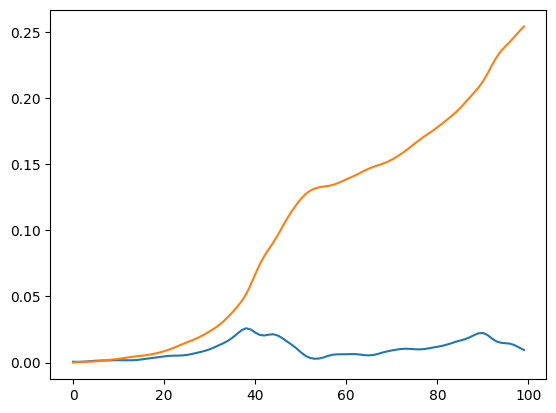

In [1199]:
t = np.arange(100)
plt.plot(SIR_sol.sol(t)[1])
plt.plot(SIR_sol.sol(t)[2])

[]

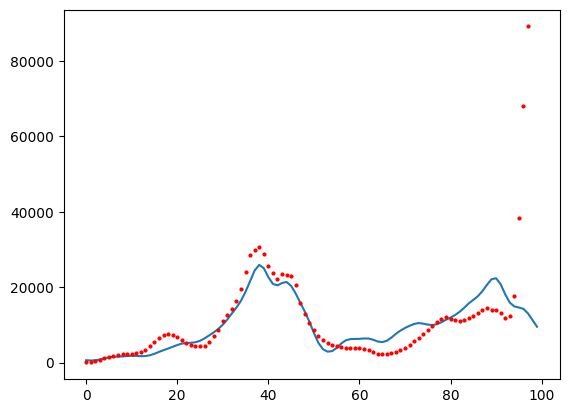

In [1200]:
all_case_data = np.concatenate((case_count_data, case_count_pred))
I_full_data = np.array([sum(all_case_data[:k]) for k in range(1, 4)] + [sum(all_case_data[k:k+4]) for k in range(len(all_case_data) - 3)])
plt.plot(SIR_sol.sol(t)[1]*P_total)
plt.plot(I_full_data,'ro', label='I data', ms = 2)
plt.plot()

In [1083]:
saved_params = {"u0":u0, "k":k, "q":q}